# Notes from Meeting with Grae:
    Compare the models predictions / how much the program would generate in returns as compared to just putting money into Vanguard / S&P 500.
    
    Look at Ryan Mitchell's notebook https://github.com/ryan-t-mitchell/thinkful/blob/master/Unit%203%20Capstone%20Final/Thinkful%20Unit%203%20Capstone%20Project.ipynb and pp https://github.com/ryan-t-mitchell/thinkful/blob/master/Unit%203%20Capstone%20Final/Thinkful%20Unit%203%20Capstone%20Project.pptm pres to see how he built his models.

# Unit 3 Capstone Project
  ## Matthew Kennedy, August 2017

   ## Section 1: Overview of Dataset and Analysis of Data
   
   The dataset used in this project comes from Kaggle user "CNuge." The dataset contains historical stock prices over the last five years for all companies in the S&P 500 index and can be found at https://www.kaggle.com/camnugent/sandp500. This project will use the files that have the historical prices for individual stocks.   
       
   The dataset contains the following columns: 
       
       Date - In the format of yy-mm-dd
       Open - Price of the stock in USD at market open
       High - Highest price reached in the day
       Low - Lowest price reached in the day
       Close - The price the stock had at the end of the day
       Volume - Number of shares traded
       Name - The stock's ticker name
       
   The user collected the data by using the python library, 'pandas_datareader,' to scrape Google Finance.

In [77]:
# Import the necessary modules
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [78]:
# This project will use the historical prices of GOOGL

# Read the Dataset, store the original
# This is the filepath on my laptop:
# original = pd.read_csv('C:\\Users\\mkennedy\\sandp500\\individual_stocks_5yr\\GOOGL_data.csv', encoding='utf-8-sig')
# This is the filepath on my desktop:
original = pd.read_csv('D:\\Data\\sandp500\\GOOGL_data.csv')

In [79]:
# Copy a dataframe of the original data to manipulate
data = original

# Print the headers of the dataframe
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL


In [61]:
# Check the footer to make sure there are no rows of text
data.tail()

,Date,Open,High,Low,Close,Volume,Name
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL
1257,8/11/2017,923.71,933.36,921.22,930.09,1616708,GOOGL


There are no footers that need to be excluded.
There are 1257 rows of stock data. 

In [62]:
# The describe method provides some additional information about the data
data.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,616.760469,621.377719,611.501638,616.599809,2.076615e+06
std,170.726853,171.626054,169.458607,170.631830,1.081167e+06
min,323.320000,326.830000,318.320000,323.910000,5.211410e+05
25%,510.217500,514.237500,504.365000,508.212500,1.453572e+06
50%,579.000000,583.625000,573.405000,579.170000,1.820138e+06
75%,758.737500,765.280000,754.065000,759.822500,2.343574e+06
max,1005.490000,1008.610000,996.620000,1004.280000,1.285814e+07


In [63]:
# The dtypes call will display the data types. 
# This is used to make sure all numerical values have the correct data type to work with in the models.
print(data.dtypes)

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object


The dataset appears to be clean and easy to work with.

Observe the correlations between columns by using seaborn's heatmap.

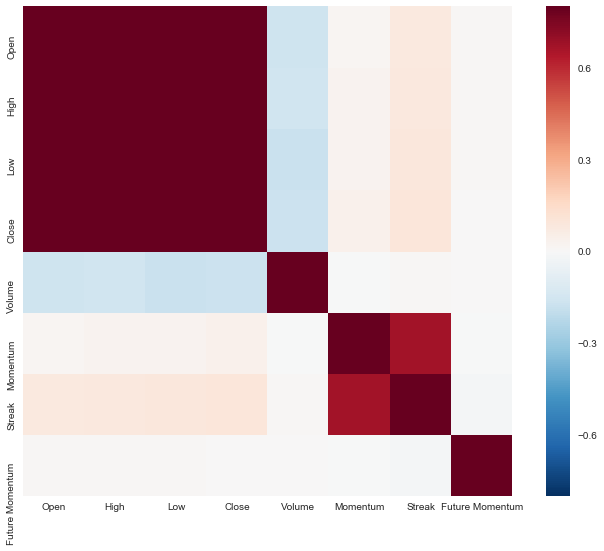

In [68]:
# Create a heatmap to compare the correlation of the columns.
import seaborn as sns

corrmat = data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

As expected, the values are highly correlated. Creating prediction models based off of time-series data will not be helpful in reaching the goal of this project (to determine whether to buy or sell the at the next opening day). 

Features will need to be created to generate accurate predictions from the models. 

In [80]:
# The momentum will show how many days in a row the stock has moved up or down. 

# Create a list to store the momentum
momentum = [0]
i=1
# Calculate the momentums and store them in the new column, 'Momentum'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            momentum.append(+1)
            i = i+1
        elif data.Close[i] < data.Close[i-1]:
            momentum.append(-1)
            i = i+1

data['Momentum'] = momentum
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1


In [41]:
# Create a 'Future Close' feature that the model will attempt to predict.
data['Future Close'] = data.Close.shift(-1)
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Future Close
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,334.66
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,334.10
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,336.77
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,338.91
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,338.11


In [47]:
data.columns.drop('Future Close')

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name', 'Momentum',
       'Streak', 'Future Momentum'],
      dtype='object')

In [81]:
streak = [0] * len(data)
i=1
# Calculate the streaks and store them in the new column, 'Streak'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            if streak[i-1] >= 0:
                streak[i] = streak[i-1]+1
                i = i+1
            else:
                streak[i]=0
                i = i+1
        elif data.Close[i] < data.Close[i-1]:
            if streak[i-1] <= 0:
                streak[i] = streak[i-1]-1
                i = i+1
            else:
                streak[i]=0
                i = i+1

data['Streak'] = streak
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2


In [82]:
# Create a 'Future Momentum' feature that the model will attempt to predict.
data['Future Momentum'] = data.Momentum.shift(-1)
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0,1.0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1,-1.0
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0,1.0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1,1.0
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2,-1.0


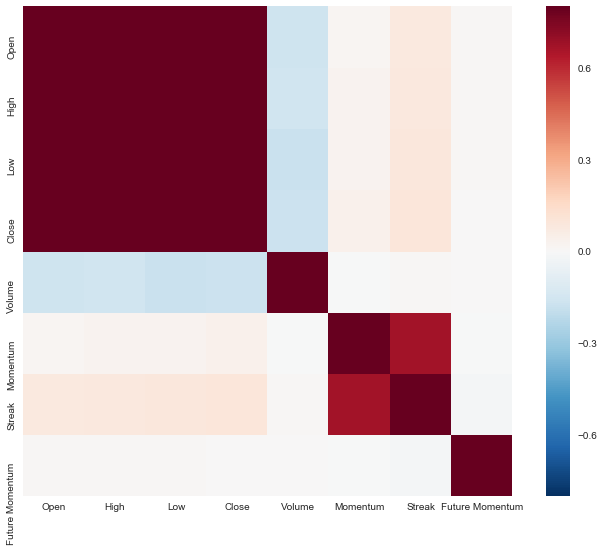

In [83]:
# Create a heatmap with the new features.

corrmat = data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

## Section 2: Creation and Comparison of Predictive Models

Now that the data has been analyzed to ensure it can be manipulated, it is time to create some predictive models. For comparison, the scores from the models will be stored in a new table, titled "Model Comparison."

In [84]:
# Create a table to store the scores for each model.
# Title: Model Comparison
# Columns: Model, R^2, Run_Time
# Model values: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regression, Gradient Boost Classification
models = {'Model':[], 'R^2':[], 'Run_Time':[]}
model_comparison = pd.DataFrame(data=models)

New features will be created to show a one week trend as well as a four week average.
### NOTE: I want to add features to show momentum (by using how many days in a row it has increased compared to its average increase or decrease), the one month, one quarter, and one year averages, etc.

In [85]:
# Set the variables. 
# Use the closing value for Y
# Use the new features for X
Y = data['Future Momentum'].values.reshape(-1, 1).astype('int')
X = data[['Close', 'Volume', 'Momentum', 'Streak']]


# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, Y_train = X[:offset], Y[:offset]

# And put 10% in the test set.
X_test, Y_test = X[offset:], Y[offset:]

### Binary Logistic Regression Classifier

In [99]:
# Declare a logistic regression classifier.
# Larger C's lead to reduced regularization of parameters, but because there are
#   few features, the value of C has a trivial effect (tested for many C's)
lr = LogisticRegression(C=1e9)

# Store the time before the model runs the train set
# Look up the other exercise where you compared run times

# Fit the model.
lr.fit(X_train, Y_train)
print('\nAccuracy for the model with train set:')
print(lr.score(X_train, Y_train))
# Make Runtime as currenttime - previoustime
print('Run time for the model with train set:')
#print(Runtime)

print('\nAccuracy for the model with test set:')
print(lr.score(X_test, Y_test))
print('Run time for the model with test set:')
#print(Runtime)
# Store the run time from the test set to the appropriate row/column for the model.


Accuracy for the model with train set:
0.519434628975
Run time for the model with train set:

Accuracy for the model with test set:
0.563492063492
Run time for the model with test set:


C:\Users\maken\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [104]:
# Use Binary Logistic Regression again, but use the two-day momentum.
# If the accuracy improves, it will show that the model can be improved.

# NOTE: Should also analyze the standard deviations of the predictions compared to the actuals as well as the normality of the residuals. Add it to all of the models. 

### Ridge Regression Classifier

In [100]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print('\nAccuracy for the model with train set:')
print(ridgeregr.score(X_train, Y_train))
print('Run time for the model with train set:')
#print(Runtime)
print('\nAccuracy for the model with test set:')
print(ridgeregr.score(X_test, Y_test))
print('Run time for the model with test set:')
#print(Runtime)
# Store the run time from the test set to the appropriate row/column for the model.


Accuracy for the model with train set:
0.00312839499699
Run time for the model with train set:

Accuracy for the model with test set:
-0.00799999993801
Run time for the model with test set:


### Lasso Regression Classifier

In [101]:
lasso = linear_model.Lasso(alpha=.35)
lasso.fit(X_train, Y_train)
print('\nAccuracy for the model with train set:')
print(lasso.score(X_train, Y_train))
print('Run time for the model with train set:')
#print(Runtime)
print('\nAccuracy for the model with test set:')
print(lasso.score(X_test, Y_test))
print('Run time for the model with test set:')
#print(Runtime)
# Store the run time from the test set to the appropriate row/column for the model.


Accuracy for the model with train set:
0.000328032232356
Run time for the model with train set:

Accuracy for the model with test set:
-0.00799999987909
Run time for the model with test set:


### Support Vector Regression Classifier

In [102]:
# Make a model using SVR here
svr = SVR()
svr.fit(X_train, Y_train)
print('\nAccuracy for the model with train set:')
print(svr.score(X_train, Y_train))
print('Run time for the model with train set:')
#print(Runtime)
print('\nAccuracy for the model with test set:')
print(svr.score(X_test, Y_test))
print('Run time for the model with test set:')
#print(Runtime)
# Store the run time from the test set to the appropriate row/column for the model.

C:\Users\maken\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Accuracy for the model with train set:
0.990015204049
Run time for the model with train set:

Accuracy for the model with test set:
-0.00799999990517
Run time for the model with test set:


### Gradient Boosting Classifier

In [103]:
# 500 iterations, using 2-deep trees, and loss function 'deviance.'
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train.ravel())
print('\nAccuracy for the model with train set:')
print(clf.score(X_train, Y_train.ravel()))
print('Run time for the model with train set:')
#print(clf.Runtime)
print('\nAccuracy for the model with test set:')
print(clf.score(X_test, Y_test.ravel()))
print('Run time for the model with test set:')
#print(Runtime)
# Store the run time from the test set to the appropriate row/column for the model.


Accuracy for the model with train set:
0.812720848057
Run time for the model with train set:

Accuracy for the model with test set:
0.420634920635
Run time for the model with test set:


## Section 3: Selection and Analysis of the Best Performing Model

Display the model comparison table here. Write up an analysis. 

# Compare the models to each other as well as to the results of buying each week 401k style.